# Multilayer Perceptron in Tensorflow 2

Hint: If you don't know the name of a tensorflow method or if you are searching for certain tensorflow implementaions, go to the online documentation at [https://www.tensorflow.org/api_docs/python/tf](https://www.tensorflow.org/api_docs/python/tf)

# Given

In [ ]:
# loading necessary libraries
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import tensorflow as tf

def plot_samples(x_train, y_train):
    ''' 
    This function takes a set of data samples and their labels as input and plots 10 samples for each class label.
    '''
    fig, axes = plt.subplots(10, 11, frameon=False, figsize=(20, 16))  # Initializes the figure with 110 suplots
    fig.subplots_adjust(hspace = .05, wspace=.001)  # Adjusts the spacing between the plots
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # The names of the 10 classes
    for i in range(len(classes)):  # Loop over the number of classes
        axes[i,0].text(0,0.5,str(i)+' : '+classes[i], fontsize=15)  # Writes the class labels in the first column of subplots 
        axes[i,0].get_xaxis().set_visible(False)  # Removes the x-axis from the plot
        axes[i,0].get_yaxis().set_visible(False)  # Removes the y-axis from the plot
        axes[i,0].set_frame_on(False)  # Makes the Background of the plot transparent

        class_idxs = np.squeeze(np.where(y_train==i))  # Finds every index corresponding to the current class
        idxs = np.random.choice(class_idxs,10)  # Picks ten random indices to plot random class examples
        for j in range(10):  # Loop over the number of samples we want to plot
            axes[i,j+1].imshow(x_train[idxs[j]], cmap='gray')  # Plots the sample Image in graysclae
            axes[i,j+1].get_xaxis().set_visible(False)  # Removes the x-axis from the plot
            axes[i,j+1].get_yaxis().set_visible(False)  # Removes the y-axis from the plot
    fig.savefig('training_examples.png', bbox_inches='tight')  # Saves the figure

def plot_false(x_test, y_test, prediction_probs):
    '''
    This function takes the predictions as output of model.predict as input. First the probabilistic prediction is converted to the most probable class label.
    Then ten random samples out of the false predictions are chosen to be plotted.
    '''
    prediction = np.argmax(prediction_probs, axis=-1)
    fig, axes = plt.subplots(4, 7, frameon=False, figsize=(28,16))  # Initializes the figure with 28 suplots
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']  # The names of the 10 classes
    false_idx = np.squeeze(np.where(y_test != prediction))  # Gets the indices of false predictions
    false_idx = np.random.choice(false_idx, 28)  # Takes 10 random indeces from the false predictions 
    x_test, y_test, prediction = x_test[false_idx], y_test[false_idx], prediction[false_idx]  # Gets the samples and labels of false predictions
    for i in range(28):  # Loop over the number of plots
        j = i // 7
        k = i % 7
        axes[j,k].imshow(x_test[i], cmap='gray')  # Plots the sample Image in graysclae
        axes[j,k].set_title('label: {} prediction: {}'.format(classes[y_test[i]], classes[prediction[i]]))  # Removes the x-axis from the plot
        axes[j,k].get_xaxis().set_visible(False)  # Removes the x-axis from the plot
        axes[j,k].get_yaxis().set_visible(False)  # Removes the y-axis from the plot
    fig.savefig('false_predictions.png', bbox_inches='tight')  # Saves the figure

def jitter(x, factor=0.05):
    '''
    Simple routine for data augmentation, as this kind is not supported by the Keras implementations.
    The jittering works by jittering or fluctuating each pixel of a sample with a random value, scaled by the given factor. 
    This has to be conducted for each sampple in seperate.
    Input: image (2D)
    Output: jittered image
    '''
    dim = np.shape(x)
    x = np.reshape(x, -1)
    jitter_scale = x*factor
    shift = [np.random.uniform(-value, value) for value in jitter_scale]
    x += shift
    x = np.reshape(x,dim)
    return x

def load_fashion_mnist():
    '''
    Downloads the fashion mnist dataset and returns it.
    '''
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return (x_train, y_train), (x_test, y_test)

# Exercise 1: Preparing the Data (2 Points)



Loading the dataset.

In [ ]:
(x_train, y_train), (x_test, y_test) = load_fashion_mnist()
print(' shape of x_train: {}\n shape of y_train: {}\n shape of x_test: {}\n shape of y_test: {}'.format(np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)))

 shape of x_train: (60000, 28, 28)
 shape of y_train: (60000,)
 shape of x_test: (10000, 28, 28)
 shape of y_test: (10000,)


Normalize the data by scaling it to unit range. **(1 Point)**

Hint: The dataset contains 8bit PNG images

In [ ]:
x_train =x_train/255.0
x_test =x_test/255.0


Take a look into the dataset by using the "plot_samples" function defined above. **(1 Point)**

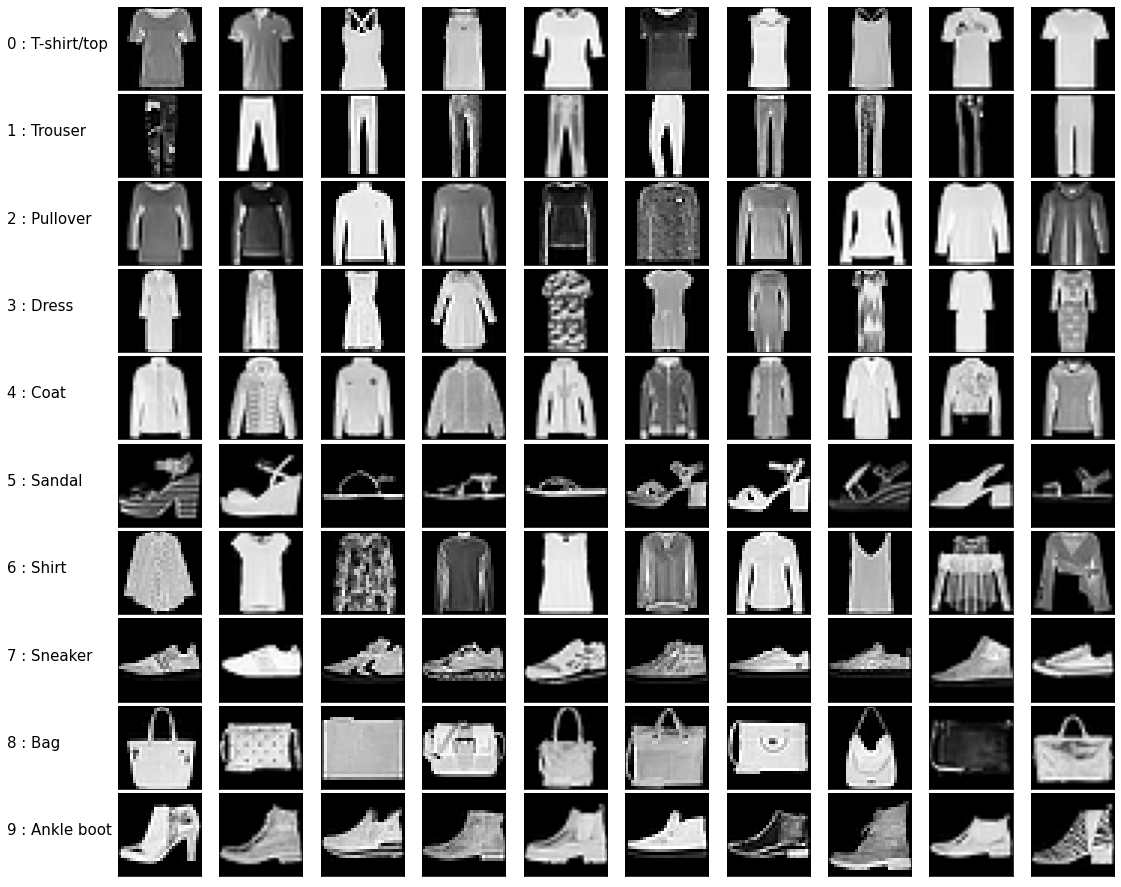

In [ ]:
plot_samples(x_train,y_train)

# The Network 

In the following tasks you are asked to implement a Multilayer perceptron. For this always implement the following network:

![](https://drive.google.com/uc?export=view&id=1VzZGOfJUqpYJFUgmmCeKEksTH06SnGXG)

For the loss function always use the sparse categorical crossentropy.

The categorical crossentropy implements the following: $$ \mathcal{L}(y, \hat y) = -y \ln(\hat y). $$

The difference between categorical crossentropy and sparse categorical crossentropy is, that the former uses the labels in their one-hot encoded form (e.g. [0,0,1,0,0,0,0,0,0,0]) and the latter uses the integer form of the label (e.g. 2), thus saving computational time and memory. 

For the optimizer take the Adam optimizer.

As additional metric use the accuracy to get a comprehensible score.

You can choose a dropout rate you like, and you can also choose any hyperparameters according to your wishes, otherwise just use the default. 

# Exercise 2: Softmax and Crossentropy (4 Points)


The Softmax activation function is defined as: $$\sigma(z_j) = \frac{e^{z_j}}{\sum_{k=1}^Ke^{z_k}} \quad for \quad j = 1,...,K$$

What is the effect on the network output when using the softmax as activation of the output layer? **(2 Points)**

Ans. Using the softmax as activation of the output layer ensures that the final activations all sum up to 1, so we would be able to interpret them as probabilities.

Why is the utilization of the softmax activation in the output layer necessary in order to use the crossentropy as loss function? **(2 Points)**

The softmax() part simply normalises your network predictions so that they can be interpreted as probabilities. Once your network is predicting a probability distribution over labels for each input, the log loss is equivalent to the cross entropy between the true label distribution and the network predictions.

```
# This is formatted as code
```



# Exercise 3: Build and evaluate the MLP with the Sequential API (2 Points) 

Build the model and compile it **(1 Points)**

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Now train the network for 10 epochs and evaluate it on the test dataset. **(1 Points)**

Make sure also incorporate a validation step on a validation dataset.

You should pick a sufficiently large batchsize, to have a faster training (~1000)

In [ ]:
model.fit(x_train, y_train, 
            batch_size=1000, 
            epochs=10, 
            validation_split=0.2)

model.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 0s 8ms/step - loss: 1.7261 - accuracy: 0.4554 - val_loss: 1.0512 - val_accuracy: 0.6149
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.9063 - accuracy: 0.6591 - val_loss: 0.7366 - val_accuracy: 0.7341
Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 0.7136 - accuracy: 0.7326 - val_loss: 0.6368 - val_accuracy: 0.7625
Epoch 4/10
48/48 [==============================] - 0s 5ms/step - loss: 0.6350 - accuracy: 0.7621 - val_loss: 0.5858 - val_accuracy: 0.7811
Epoch 5/10
48/48 [==============================] - 0s 5ms/step - loss: 0.5884 - accuracy: 0.7836 - val_loss: 0.5492 - val_accuracy: 0.7974
Epoch 6/10
48/48 [==============================] - 0s 5ms/step - loss: 0.5542 - accuracy: 0.7962 - val_loss: 0.5222 - val_accuracy: 0.8107
Epoch 7/10
48/48 [==============================] - 0s 5ms/step - loss: 0.5255 - accuracy: 0.8118 - val_loss: 0.4978 - val_accuracy: 0.8198
Epoch 8/10
48/48 [==

[0.48524442315101624, 0.8246999979019165]

# Exercise 4: Build and evaluate the MLP with the Functional API (2 Points) 

Build the model and compile it. **(1 Points)**

In [ ]:
inputs = tf.keras.Input(shape=(28, 28), name='img')
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Now train the network for 10 epochs and evaluate it on the test dataset. **(1 Points)**

Make sure also incorporate a validation step on a validation dataset.

You should pick a sufficiently large batchsize, to have a faster training (~1000)

In [ ]:
model.fit(x_train, y_train,
          batch_size=1000,
          epochs=10,
          validation_split=0.3)

model.evaluate(x_test, y_test, verbose=0)

Epoch 1/10
42/42 [==============================] - 0s 6ms/step - loss: 0.4062 - accuracy: 0.8531 - val_loss: 0.4038 - val_accuracy: 0.8524
Epoch 2/10
42/42 [==============================] - 0s 5ms/step - loss: 0.4018 - accuracy: 0.8553 - val_loss: 0.3972 - val_accuracy: 0.8535
Epoch 3/10
42/42 [==============================] - 0s 5ms/step - loss: 0.3940 - accuracy: 0.8579 - val_loss: 0.3920 - val_accuracy: 0.8576
Epoch 4/10
42/42 [==============================] - 0s 5ms/step - loss: 0.3880 - accuracy: 0.8600 - val_loss: 0.3900 - val_accuracy: 0.8582
Epoch 5/10
42/42 [==============================] - 0s 5ms/step - loss: 0.3814 - accuracy: 0.8621 - val_loss: 0.3837 - val_accuracy: 0.8608
Epoch 6/10
42/42 [==============================] - 0s 5ms/step - loss: 0.3789 - accuracy: 0.8624 - val_loss: 0.3817 - val_accuracy: 0.8598
Epoch 7/10
42/42 [==============================] - 0s 5ms/step - loss: 0.3726 - accuracy: 0.8659 - val_loss: 0.3792 - val_accuracy: 0.8620
Epoch 8/10
42/42 [==

[0.39922377467155457, 0.8550999760627747]

# Exercise 5: Build and evaluate the MLP with the Subclassing API (6 Points) 

Build the datasets for training, validation and testing using the already imported and normalized data. **(1 Point)**

For this you also have to write a function casting the data to the correct tensorflow datatype. (choose float32 for the images and int64 for the labels)

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model

def prepare_mnist_features_and_labels(x, y):
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.cast(y, tf.int64)
  return x, y

def fashion_mnist_dataset():
  (x, y), _ = tf.keras.datasets.fashion_mnist.load_data()
  x, y = x[:int(0.8*len(x))], y[:int(0.8*len(y))]
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels, num_parallel_calls=2) 
  ds = ds.take(60000).shuffle(60000).batch(1000, drop_remainder=False)
  return ds

def fashion_mnist_validation_dataset():
  (x, y), _ = tf.keras.datasets.fashion_mnist.load_data()
  x, y = x[int(0.8*len(x)):], y[int(0.8*len(y)):]
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels, num_parallel_calls=2) 
  ds = ds.take(60000).shuffle(60000).batch(1000, drop_remainder=False)
  return ds

def fashion_mnist_test_dataset():
  _, (x, y) = tf.keras.datasets.fashion_mnist.load_data()
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels, num_parallel_calls=None)
  ds = ds.take(-1).batch(1000, drop_remainder=False)
  return ds

train_dataset = fashion_mnist_dataset()
for x, y in train_dataset:
  print(np.shape(x))
  break
validation_dataset = fashion_mnist_validation_dataset()
test_dataset = fashion_mnist_test_dataset()


(1000, 28, 28)


Now build the model with the subclassing API. **(1 Point)**

In [ ]:
class MyModel(tf.keras.Model):
    def __init__(self):
      super(MyModel, self).__init__()
      self.flatten = Flatten()
      self.dense1 = Dense(1024, activation='relu')
      self.dense2 = Dense(512, activation='relu')
      self.dense3 = Dense(10, activation='softmax')
      self.drop1 = Dropout(0.2)
      self.drop2 = Dropout(0.2)


    def call(self, x):
      x = self.flatten(x)
      x = self.dense1(x)
      x = self.drop1(x)
      x = self.dense2(x)
      x = self.drop2(x)
      x = self.dense3(x)
      return x

model = MyModel()


Define the loss, optimizer and accuracy metrics. **(1 Point)**

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

validation_loss = tf.keras.metrics.Mean(name='validation_loss')
validation_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='validation_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

Define the training step, the validation step and the testing step. **(1 Point)**

In [ ]:
@tf.function
def train_step(Model, images, labels):
  with tf.GradientTape() as tape:
    predictions = Model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, Model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, Model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)


In [ ]:
@tf.function
def validation_step(Model, images, labels):
  predictions = Model(images)
  v_loss = loss_object(labels, predictions)

  validation_loss(v_loss)
  validation_accuracy(labels, predictions)

In [ ]:
@tf.function
def test_step(Model, images, labels):
  predictions = Model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)


Write a function for the training loop. **(1 Points)**

The function should print the loss and accuracy for training and validation in a readable manner. 

Make sure to reset the loss and accuracy metrics after every epoch.

In [ ]:
def train_loop(EPOCHS=0):
  for epoch in range(EPOCHS):
    for images, labels in train_dataset:
      train_step(model, images, labels)

    for validation_images, validation_labels in validation_dataset:
      validation_step(model, validation_images, validation_labels)

    template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.4f}, Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
    print (template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result(),
                          validation_loss.result(),
                          validation_accuracy.result()))

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    validation_loss.reset_states()
    validation_accuracy.reset_states()

Now train the model for 10 epochs and evalaute it on the test dataset. **(1 Point)** 

In [ ]:
train_loop(10)

for test_images, test_labels in test_dataset:
  test_step(model, test_images, test_labels)

template = 'Test Loss: {:.4f}, Test Accuracy: {:.4f}'
print (template.format(test_loss.result(), test_accuracy.result()))

Epoch 1, Loss: 0.6753, Accuracy: 0.7660, Validation Loss: 0.4526, Validation Accuracy: 0.8389
Epoch 2, Loss: 0.4126, Accuracy: 0.8537, Validation Loss: 0.3840, Validation Accuracy: 0.8650
Epoch 3, Loss: 0.3515, Accuracy: 0.8747, Validation Loss: 0.3721, Validation Accuracy: 0.8700
Epoch 4, Loss: 0.3256, Accuracy: 0.8822, Validation Loss: 0.3462, Validation Accuracy: 0.8763
Epoch 5, Loss: 0.3014, Accuracy: 0.8894, Validation Loss: 0.3529, Validation Accuracy: 0.8725
Epoch 6, Loss: 0.2810, Accuracy: 0.8976, Validation Loss: 0.3166, Validation Accuracy: 0.8842
Epoch 7, Loss: 0.2687, Accuracy: 0.9010, Validation Loss: 0.3115, Validation Accuracy: 0.8882
Epoch 8, Loss: 0.2515, Accuracy: 0.9073, Validation Loss: 0.3277, Validation Accuracy: 0.8804
Epoch 9, Loss: 0.2387, Accuracy: 0.9120, Validation Loss: 0.3047, Validation Accuracy: 0.8898
Epoch 10, Loss: 0.2278, Accuracy: 0.9167, Validation Loss: 0.3038, Validation Accuracy: 0.8913
Test Loss: 0.3273, Test Accuracy: 0.8816


# Exercise 6: Get better results (10 Points)


For this task you can pick an API of your choice. You should stick to the same architecture.

The goal is to reach an accuracy on the test data of at least 0.9

For this you should:

1.   fiddle around with the hyperparameters of you model (most importantly the droprate)
2.   Apply preprocessing to the training data. You can find possible techniques for this in the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image) or e.g. the jitter function defined in the first code cell. 

Define the network and compile it.

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Apply preprocessing to the data

In [ ]:
x_train=jitter(x_train,0.04)

Train the network

In [ ]:
model.fit(x_train, y_train, 
            batch_size=1000, 
            epochs=10, 
            validation_split=0.2)

model.evaluate(x_test, y_test)

Epoch 1/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9672 - val_loss: 0.3943 - val_accuracy: 0.9018
Epoch 2/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0890 - accuracy: 0.9654 - val_loss: 0.3795 - val_accuracy: 0.9019
Epoch 3/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0821 - accuracy: 0.9689 - val_loss: 0.3775 - val_accuracy: 0.9022
Epoch 4/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0783 - accuracy: 0.9705 - val_loss: 0.3910 - val_accuracy: 0.9020
Epoch 5/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0800 - accuracy: 0.9702 - val_loss: 0.3893 - val_accuracy: 0.9005
Epoch 6/10
48/48 [==============================] - 0s 4ms/step - loss: 0.0827 - accuracy: 0.9692 - val_loss: 0.3709 - val_accuracy: 0.9058
Epoch 7/10
48/48 [==============================] - 0s 5ms/step - loss: 0.0842 - accuracy: 0.9679 - val_loss: 0.3907 - val_accuracy: 0.9015
Epoch 8/10
48/48 [==

[0.44082123041152954, 0.9002000093460083]

Result Acquired

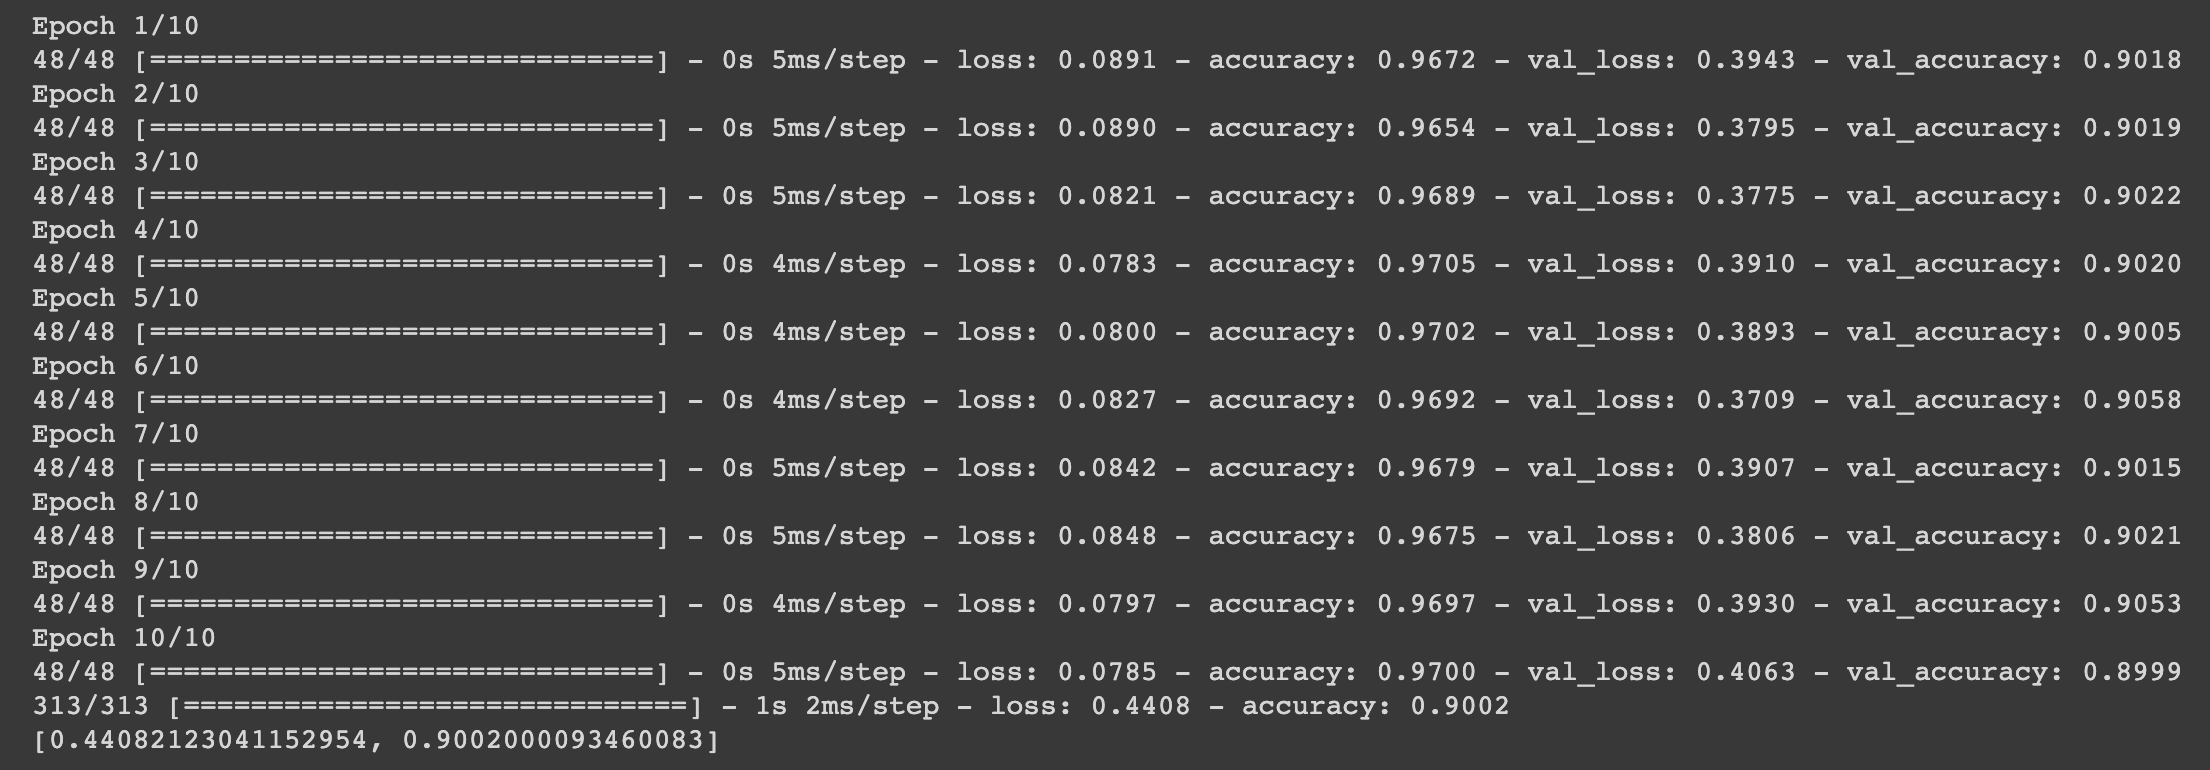 

# Exercise 7: Explain the bad results (3 Points)

Get the predictions and look at some of the falsely predicted results.


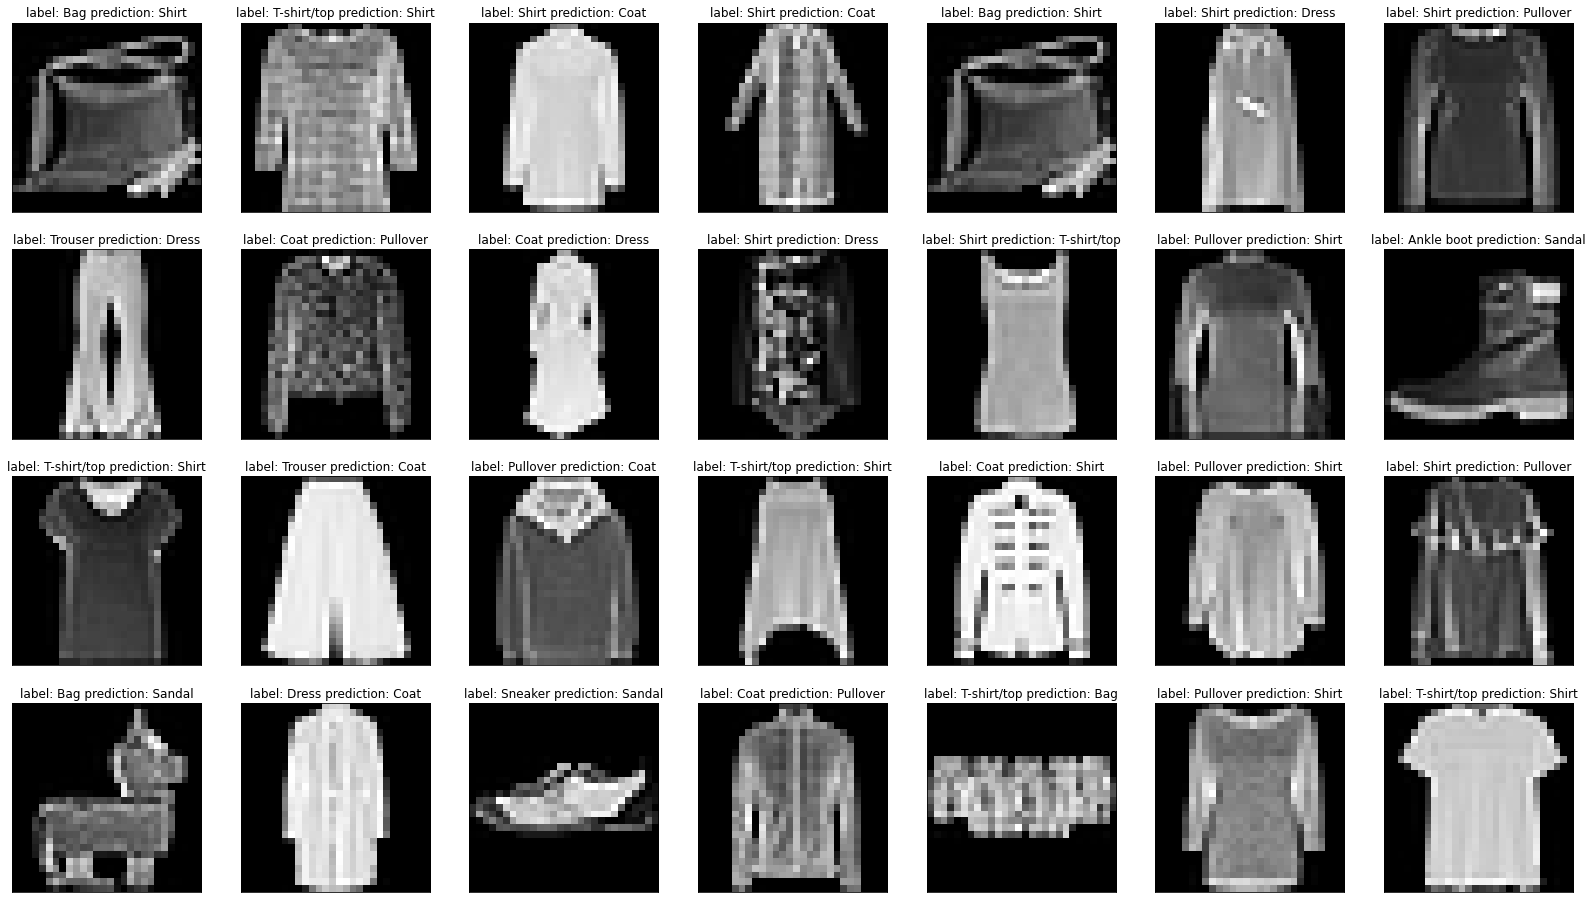

In [ ]:
predictions = model.predict(x_test)
plot_false(x_test,y_test,predictions)

Now explain why the network is hardly able to get an accuracy notably higher than 0.9 **(5 Points)**

The wrong predictions are very similar to correct labels, the model is not able to acheive higher accuracy than 0.9 is because even human eye would not be able to make such correct predictions.